In [1]:
!pip install tensorflow_recommenders

# Installs and imports
import pandas as pd
import numpy as np
import tensorflow_recommenders as tfrs
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import Dict, Text
import random
from collections import Counter
import gc
from datetime import timedelta
from IPython.display import clear_output
from tensorflow import feature_column
from tensorflow.keras import layers
clear_output()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
movies_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/movies_metadata.csv")
users_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/user_metadata.csv")
rating = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/CG_rating.csv")

rating.loc[:, "date"] = pd.to_datetime(rating.timestamp, unit='s')
rating[['userId', 'movieId']] = rating[['userId', 'movieId']].astype(str)
movies_metadata['id'] = movies_metadata['id'].astype(str)
users_metadata['userId'] = users_metadata['userId'].astype(str)

<ipython-input-3-642690a2bb1e>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rating.loc[:, "date"] = pd.to_datetime(rating.timestamp, unit='s')


In [ ]:
# usersinfo = rating.groupby('userId')['movieId'].nunique().reset_index()
# users = usersinfo[(usersinfo['movieId']>=20) & (usersinfo['movieId']<=500)]['userId'].values
# rating = rating[rating['userId'].isin(users)]
# rating = rating[rating['rating']>=3]

In [5]:
# Intersection helper function 
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
def estimate_recall(cg, purchase):
    return len(intersection(cg,purchase))/len(purchase)

In [6]:
N_DAYS_TRAIN = (rating.date.max() - rating.date.min()).days * 0.8
N_DAYS_TEST = (rating.date.max() - rating.date.min()).days * 0.2

max_date = rating['date'].max()
train = rating[(rating['date']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TRAIN+N_DAYS_TEST)).date().strftime('%Y-%m-%d')))
                        & (rating['date']<((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]
test = rating[(rating['date']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]

del rating
gc.collect()

0

In [7]:
c1 = train['userId'].to_list()
c2 = test['userId'].to_list()

# Note: Sorting common_users so evaluation is deterministic
common_users = sorted(intersection(c1, c2))

print(len(train), len(test), len(c1), len(c2), len(common_users))

2318457 725165 2318457 725165 629


In [8]:
def run_candidate_generation(method, k_values=[100,1000], user_set_size=100):
    """
    Evaluate a given candidate generator in terms of recall on the held-out test set.

    Args:
        method (function): Candidate generation function. User ID (u) and number of candidates (k) arguments.
        k_values (list): List of number of candidates to generate and evaluate.
        user_set_size (int): Number of users to evaluate.

    Returns:
        None. Prints results.
    """

    # Initialise evaluation variables
    k_values = sorted(k_values)
    recall_dict = {k:0 for k in k_values}    
    user_set = common_users[:user_set_size]
    recall_list_dict = {k:[] for k in k_values}

    # Loop over users
    for u in tqdm(user_set):
        # Get list of purchased items for user u
        purchase_list = test[test['userId']==u]['movieId'].to_list()
        # Run candidate generation
        cg = method(u, max(k_values))
        for k in k_values:
            # Estimate recall for candidate generator
            recall = estimate_recall(cg[:k], purchase_list)
            # Add this to overall recall (to be averaged at end)
            recall_dict[k] += recall
            recall_list_dict[k] += [recall]

    print(f"\nRecall evaluation for {user_set_size:,} users:")
    for k in k_values:
        # Average recall by dividing sum of recalls by user_set length
        overall_recall = recall_dict[k] / len(user_set)
        print(f"Recall @ {k} Candidates: {overall_recall:.5f}")
        print(f"Recall @ {k} Candidates Max: {max(recall_list_dict[k]):.5f}")
        print(f"Recall @ {k} Candidates Min: {min(recall_list_dict[k]):.5f}")

In [9]:
trainAddFeatures = train.merge(users_metadata, on='userId').merge(movies_metadata, left_on='movieId', right_on='id')
del train
gc.collect()
trainAddFeatures.head(3)

,userId,movieId,rating,timestamp,date,total_movies,userAvgRating,userAvgBudget,userTopLanguages,userTopGenres,...,production_companies,production_countries,revenue,runtime,spoken_languages,video,vote_average,vote_count,movie_age,abstract_col
0,2,5,3.0,867039249,1997-06-23 04:14:09,8,4.0,6392734.5,en,Romance,...,Miramax Films,United States of America,4300000,98,English,False,6.5,539.0,10005.0,crime comedy miramax films a band apart united...
1,40,5,4.0,862515493,1997-05-01 19:38:13,13,4.0,4000000.0,en,Action,...,Miramax Films,United States of America,4300000,98,English,False,6.5,539.0,10005.0,crime comedy miramax films a band apart united...
2,54,5,5.0,986221889,2001-04-02 14:31:29,17,4.0,0.0,en,Comedy,...,Miramax Films,United States of America,4300000,98,English,False,6.5,539.0,10005.0,crime comedy miramax films a band apart united...


In [10]:
# movies information
mvs_numerical_column = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'movie_age']
mvs_categorical_column = ['id', 'production_companies', 'production_countries', 'spoken_languages', 'genres']

#users inforamtion
users_numerical_column = ['total_movies', 'userAvgRating', 'userAvgBudget', 'userAvgPopularity', 
                            'userAvgMovieAge', 'userAvgRuntime']
users_categorical_column = ['userId', 'userTopPH', 'userTopGenres']

In [11]:
# Create lists of unique ids
unique_categories = {}
for mvs in mvs_categorical_column + users_categorical_column:
    if mvs not in ['userId', 'movieId']:
        trainAddFeatures[mvs] = trainAddFeatures[mvs].astype(str)
    unique_categories[mvs] = trainAddFeatures[mvs].unique()

In [54]:
embedding_dimension = 16

In [55]:
class CustomerModelWithAge(tf.keras.Model):
  def __init__(self, ratings):
    super().__init__()
    self.keras_layers = []
    for col in users_categorical_column:
        self.keras_layers.append(tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_categories[col], 
                mask_token=None),
                tf.keras.layers.Embedding(len(unique_categories[col]) + 1, 
                                        embedding_dimension//16)]))
    for col in users_numerical_column:
        self.normalizer = tf.keras.layers.Normalization(axis=None)
        self.normalizer.adapt(ratings.map(lambda x: x[col]).batch(1024*128))
        self.keras_layers.append(tf.keras.Sequential([self.normalizer, tf.keras.layers.Reshape([1])]))
        
  def call(self, inputs):
    cols = users_categorical_column + users_numerical_column
    return tf.concat([self.keras_layers[i](inputs[cols[i]]) for i in range(len(cols))], axis=1)


In [56]:
class ArticleModelWithProductGroup(tf.keras.Model):
  def __init__(self, ratings):
    super().__init__()
    self.keras_layers = []
    for col in mvs_categorical_column:
        self.keras_layers.append(tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_categories[col], 
                mask_token=None),
                tf.keras.layers.Embedding(len(unique_categories[col]) + 1, 
                                        embedding_dimension//16)]))
    
    for col in mvs_numerical_column:
        self.normalizer = tf.keras.layers.Normalization(axis=None)
        self.normalizer.adapt(ratings.map(lambda x: x[col]).batch(1024*128))
        self.keras_layers.append(tf.keras.Sequential([self.normalizer, tf.keras.layers.Reshape([1])]))
        
  def call(self, inputs):
    cols = mvs_categorical_column + mvs_numerical_column
    return tf.concat([self.keras_layers[i](inputs[cols[i]]) for i in range(len(cols))], axis=1)


In [57]:
class HandMModelAddFeatures(tfrs.Model):
  def __init__(self, ratings, articles_add):
      super().__init__()
      # Since concatenating additional features varied the feature dimensions
      # Make sure customer and article models output embeddings of compatible size here
      self.customer_model = tf.keras.Sequential([
        CustomerModelWithAge(ratings),
        tf.keras.layers.Dense(embedding_dimension, activation='relu'),
        tf.keras.layers.Dense(embedding_dimension, activation='relu')
      ])
      self.article_model = tf.keras.Sequential([
        ArticleModelWithProductGroup(ratings),
        tf.keras.layers.Dense(embedding_dimension, activation='relu'),
        tf.keras.layers.Dense(embedding_dimension, activation='relu')
      ])
      self.task = tfrs.tasks.Retrieval(
          metrics=tfrs.metrics.FactorizedTopK(
          candidates=articles_add.batch(1024*128).map(self.article_model),
          ),
      )        

  def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
      # Here we ensure training and query input have same keys 
      # Otherwise the discrepancy in input structure would cause an error when loading the query model after saving it.
      customer_embeddings = self.customer_model({
          col: features[col] for col in users_categorical_column + users_numerical_column
        })
      
      article_embeddings = self.article_model({
          col: features[col] for col in mvs_categorical_column + mvs_numerical_column
        })

      return self.task(customer_embeddings, article_embeddings, compute_metrics=not training)

In [50]:
movies_metadata[mvs_categorical_column] = movies_metadata[mvs_categorical_column].fillna('other')

In [58]:
article_add_ds = tf.data.Dataset.from_tensor_slices(dict(movies_metadata[mvs_categorical_column + mvs_numerical_column]))
articles_add = article_add_ds.map(lambda x: {
    col: x[col] for col in mvs_categorical_column + mvs_numerical_column
    })
ratings = tf.data.Dataset.from_tensor_slices(dict(trainAddFeatures[users_numerical_column + mvs_numerical_column]))

In [59]:
model = HandMModelAddFeatures(ratings, articles_add)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [60]:
# The `from_tensor_slices` method creates a dataset with a separate element for each row of the input tensor
# Shuffling randomly shuffles the dataset and batching sets the batch size to 256
# Caching keeps the dataset in memory (or a specified file). For larger datasets sometimes we cannot fit the entire dataset in memory and thus use a file on disk.
train_add_ds = tf.data.Dataset.from_tensor_slices(dict(trainAddFeatures[users_categorical_column + users_numerical_column + mvs_categorical_column + mvs_numerical_column])).shuffle(100_000, seed=42).batch(1024*24).cache()

In [ ]:
# Fit the model
# FactorizedTopK will show as 0, but these are the expensive metrics and as training=True they will not be calculated
num_epochs = 128
history = model.fit(train_add_ds, epochs=num_epochs, verbose=1, batch_size=1024*48)

Epoch 1/128


48/48 [==============================] - 70s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 245650.3106 - regularization_loss: 0.0000e+00 - total_loss: 245650.3106
Epoch 2/128
48/48 [==============================] - 10s 210ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 241793.8093 - regularization_loss: 0.0000e+00 - total_loss: 241793.8093
Epoch 3/128
48/48 [==============================] - 10s 212ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - fac

In [24]:
testAddFeatures = test.merge(users_metadata, on='userId').merge(movies_metadata, left_on='movieId', right_on='id')
testAddFeatures.head(3)

,userId,movieId,rating,timestamp,date,total_movies,userAvgRating,userAvgBudget,userTopLanguages,userTopGenres,...,production_companies,production_countries,revenue,runtime,spoken_languages,video,vote_average,vote_count,movie_age,abstract_col
0,201,111,5.0,1498091669,2017-06-22 00:34:29,88,4.5,1003474.0,en,Thriller,...,Universal Pictures,United States of America,65884703,170,English,False,8.0,3017.0,14389.0,action crime thriller universal pictures unite...
1,3896,111,4.0,1374706654,2013-07-24 22:57:34,16,4.0,3500000.0,en,Comedy,...,Universal Pictures,United States of America,65884703,170,English,False,8.0,3017.0,14389.0,action crime thriller universal pictures unite...
2,4494,111,3.5,1435548874,2015-06-29 03:34:34,32,4.5,1394000.0,en,Comedy,...,Universal Pictures,United States of America,65884703,170,English,False,8.0,3017.0,14389.0,action crime thriller universal pictures unite...


In [25]:
# Take a sample of 2000 elements from the test set and run inference on them
test_add_ds = tf.data.Dataset.from_tensor_slices(dict(testAddFeatures.sample(2000, random_state=42)[users_categorical_column + users_numerical_column + mvs_categorical_column + mvs_numerical_column])).batch(1024*512).cache()

# We now see the metrics are not in fact zero (train=False here, so they are computed)
model.evaluate(test_add_ds, return_dict=True)

1/1 [==============================] - 2s 2s/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0015 - factorized_top_k/top_50_categorical_accuracy: 0.0060 - factorized_top_k/top_100_categorical_accuracy: 0.0145 - loss: 16741.4121 - regularization_loss: 0.0000e+00 - total_loss: 16741.4121


{'factorized_top_k/top_1_categorical_accuracy': 0.0005000000237487257,
 'factorized_top_k/top_5_categorical_accuracy': 0.0010000000474974513,
 'factorized_top_k/top_10_categorical_accuracy': 0.001500000013038516,
 'factorized_top_k/top_50_categorical_accuracy': 0.006000000052154064,
 'factorized_top_k/top_100_categorical_accuracy': 0.014499999582767487,
 'loss': 16741.412109375,
 'regularization_loss': 0,
 'total_loss': 16741.412109375}

In [26]:
article_ds = tf.data.Dataset.from_tensor_slices(dict(movies_metadata[['id']]))
articles = article_ds.map(lambda x: x['id'])

In [27]:
article_add_ds = tf.data.Dataset.from_tensor_slices(dict(movies_metadata[mvs_categorical_column + mvs_numerical_column]))
articles_add = article_add_ds.map(lambda x: {
    col: x[col] for col in mvs_categorical_column + mvs_numerical_column
    })
# ratings = tf.data.Dataset.from_tensor_slices(dict(testAddFeatures[users_numerical_column + mvs_numerical_column]))

In [28]:
# Create an index that takes in raw customer features, and recommends articles out of the entire dataset
index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model)
index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(1000), articles_add.batch(1000).map(model.article_model)))
)

In [29]:
def get_top_k_candidates_2_tower(user_set, k, model):
    """
    Generate k candidates from the training set using the two-tower model.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.
        model (class): Models to predict the candidate.

    Returns:
        result (list): The top-k candidates.
    """

    size = len(user_set)
    batch_size = 100
    steps = size//batch_size
    if size%batch_size>0:
        steps+=1
        
    result = []
    for i in range(steps):
        userId = user_set[i*(batch_size):(i+1)*batch_size]
        users = {}
        df_tmp = testAddFeatures[testAddFeatures['userId'].isin(userId)].drop_duplicates(subset='userId')
        if len(df_tmp)>0:
            for column in mvs_categorical_column + users_categorical_column + mvs_numerical_column + users_numerical_column:
                users[column] = tf.constant(df_tmp[column].to_list())
            _, candidates = index(users, k=k)
            candidates = candidates.numpy()
            idx = []
            for x in candidates:
                count = 0
                decode_result = {}
                for c in x:
                    c_decode = c.decode("utf-8")
                    if c_decode not in decode_result:
                        decode_result[c_decode] = 1
                        count += 1
                    if count == k:
                        break
                idx.append(list(decode_result.keys()))
            result.extend(idx)
    return result

In [30]:
common_users = testAddFeatures[testAddFeatures['userId'].isin(trainAddFeatures['userId'])]['userId'].unique()

In [31]:
k_values = sorted([10,100])
user_set = common_users[:10]
result = test[test['userId'].isin(user_set)].groupby('userId').agg({'movieId': list}).reset_index()
result["len"] = result['movieId'].apply(len)

In [32]:
def run_candidate_generation(method, common_users, model=None, k_values=[100, 1000], user_set_size=100,
                             id_variable="userId", label_variable="movieId"):
    """
    Evaluate a given candidate generator in terms of recall on the held-out test set.

    Args:
        method (function): Candidate generation function. User ID (u) and number of candidates (k) arguments.
        k_values (list): List of number of candidates to generate and evaluate.
        user_set_size (int): Number of users to evaluate.
        model (class) : Model that we used for prediction. None if we use non-learn model
        common_users (pd.Dataframe): dataframe of common users between (train and validation) or (train and test) to be evaluated.
        columns_model (list of string): List of columns name that used in model. None if we use non-learn model
        id_variable (string): user id column name
        label_variable (string): content id column name

    Returns:
        recall_agg : Statistical Summary of the recall performanec
        result : Recall performance for each of data in common users
    """

    # Initialise evaluation variables
    k_values = sorted(k_values)
    user_set = common_users[:user_set_size]
    result = testAddFeatures[testAddFeatures['userId'].isin(user_set)].groupby('userId').agg({'movieId': list}).reset_index()
    result["len"] = result['movieId'].apply(len)

    cg = method(user_set, max(k_values), model)
    for k in k_values:
        result[f"recs@{k}"] = pd.Series(cg).apply(lambda x: x[:k])
        result[f"intersect_len@{k}"] = [len(set(a).intersection(b)) for a, b in
                                        zip(result[label_variable], result[f"recs@{k}"])]
        result[f"recall@{k}"] = result[f"intersect_len@{k}"] / result["len"]

    # Evaluation recall@K
    recall_agg = {}
    for k in k_values:
        recall_agg[k] = {"overall_recall": sum(result[f"recall@{k}"]) / len(result),
                      "min_recall": min(result[f'recall@{k}']),
                      "max_recall": max(result[f'recall@{k}']),
                      "mean_recall": np.mean(result[f'recall@{k}']),
                      "median_recall": np.median(result[f'recall@{k}'])}

    return recall_agg, result

In [33]:
performance_test_agg, df_performance_test = run_candidate_generation(get_top_k_candidates_2_tower, common_users, model, user_set_size=None)

array([b'111', b'111', b'111', b'111', b'111', b'111', b'111', b'111',
       b'111', b'111', b'111', b'111', b'111', b'111', b'111', b'111',
       b'111', b'111', b'111', b'111', b'111', b'111', b'111', b'111',
       b'111', b'111', b'111', b'111', b'111', b'111', b'111', b'111',
       b'111', b'111', b'111', b'111', b'111', b'111', b'111', b'111',
       b'111', b'671', b'671', b'26614', b'26614', b'26614', b'26614',
       b'26614', b'26614', b'26614', b'26614', b'26614', b'26614',
       b'26614', b'26614', b'26614', b'26614', b'26614', b'26614',
       b'26614', b'26614', b'26614', b'26614', b'26614', b'81847',
       b'81847', b'81847', b'81847', b'81847', b'81847', b'81847',
       b'81847', b'81847', b'81847', b'81847', b'81847', b'81847',
       b'81847', b'81847', b'81847', b'81847', b'81847', b'81847',
       b'81847', b'81847', b'81847', b'81847', b'81847', b'84152',
       b'84152', b'84152', b'84152', b'84152', b'84152', b'84152',
       b'84152', b'84152', b'84152', b

In [34]:
performance_test_agg

{100: {'overall_recall': 0.014268787341532608,
  'min_recall': 0.0,
  'max_recall': 1.0,
  'mean_recall': 0.014268787341532608,
  'median_recall': 0.0},
 1000: {'overall_recall': 0.16528824214227644,
  'min_recall': 0.0,
  'max_recall': 1.0,
  'mean_recall': 0.16528824214227647,
  'median_recall': 0.07051282051282051}}

In [35]:
df_performance_test

,userId,movieId,len,recs@100,intersect_len@100,recall@100,recs@1000,intersect_len@1000,recall@1000
0,10045,"[923, 590, 924, 17, 4326, 1673, 1610, 161]",8,"[232005, 391934, 211672, 261035, 14160, 250332...",0,0.0,"[232005, 391934, 211672, 261035, 14160, 250332...",1,0.125000
1,10048,"[296, 85414, 5618, 5971, 31658, 127098, 293, 6...",12,"[315837, 99258, 6610, 34214, 7839, 25903, 8980...",0,0.0,"[315837, 99258, 6610, 34214, 7839, 25903, 8980...",1,0.083333
2,10279,[364],1,"[44657, 5473, 70846, 99258, 33709, 26850, 9812...",0,0.0,"[44657, 5473, 70846, 99258, 33709, 26850, 9812...",0,0.000000
3,10311,"[84152, 4011, 85414, 30707, 46578, 54001, 7445...",27,"[86576, 211672, 98122, 47940, 70846, 5473, 441...",0,0.0,"[86576, 211672, 98122, 47940, 70846, 5473, 441...",8,0.296296
4,10338,"[58559, 4975, 541, 1584, 1653, 46578, 67255, 1...",27,"[14160, 281338, 166426, 232005, 315837, 391934...",0,0.0,"[14160, 281338, 166426, 232005, 315837, 391934...",2,0.074074
...,...,...,...,...,...,...,...,...,...
536,9401,"[1251, 858, 778, 912, 922, 1244, 2360, 1635, 2...",11,"[14160, 211672, 146015, 110415, 31200, 28967, ...",0,0.0,"[14160, 211672, 146015, 110415, 31200, 28967, ...",0,0.000000
537,9427,"[111, 608, 215, 293, 6440, 16, 1244, 1249, 310...",14,"[315837, 25903, 50182, 6610, 7301, 8980, 78235...",0,0.0,"[315837, 25903, 50182, 6610, 7301, 8980, 78235...",5,0.357143
538,9455,[44555],1,"[5473, 70846, 44124, 87683, 26366, 31973, 9812...",0,0.0,"[5473, 70846, 44124, 87683, 26366, 31973, 9812...",1,1.000000
539,9914,"[6016, 3681, 58559, 5618, 5995, 2324, 2502, 70...",12,"[232005, 211672, 26317, 391934, 44657, 225503,...",0,0.0,"[232005, 211672, 26317, 391934, 44657, 225503,...",1,0.083333


<Axes: ylabel='Frequency'>

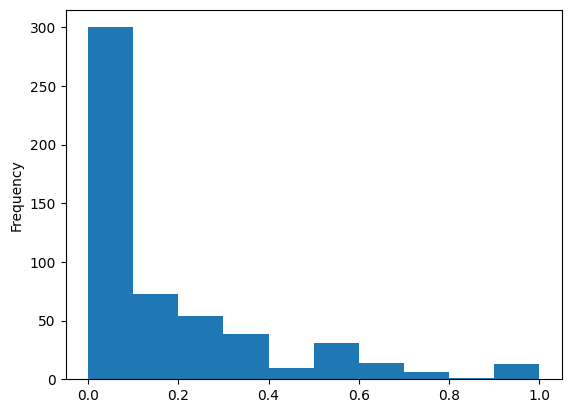

In [36]:
df_performance_test['recall@1000'].plot(kind='hist')

# Save Model

In [ ]:
model.save_weights('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/CG_weights', save_format='tf')

In [ ]:
tf.data.Dataset.save(ratings, "/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/rating_tensor")

In [ ]:
tf.data.Dataset.save(articles_add, '/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/articles_add')

In [ ]:
# Create lists of unique ids
unique_categories = {}
for mvs in mvs_categorical_column + users_categorical_column:
    unique_categories[mvs] = list(trainAddFeatures[mvs].unique())

In [ ]:
import json
json.dump(unique_categories, open( "/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/unique_categories.json", 'w' ) )